# BÁO CÁO CUỐI KỲ
Thành viên: 
- Huỳnh Ngọc Thuật
- Đoàn Tân Tỵ
- Hường Lê Nguyên

## I.Phát biểu bài toán

Dữ liệu được nhóm crawl từ trang https://pokemondb.net/ chứa thông tin về chỉ số cơ bản của mỗi pokemon
- Mục tiêu của bài toán:
- Thuật toán sử dụng: Kmeans Clustering, Hierarchical Clustering, DBSCAN Clustering

## II.Các bước triển khai

#### 1. Import các thư viện cần thiết

In [42]:
import numpy as np
import pandas as pd
import matplotlib
import scipy.stats as stat
matplotlib.use('nbagg')
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
sns.set()
from sklearn.cluster import KMeans
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
import matplotlib.patheffects as PathEffects

#### 2. Đọc dữ liệu pokemon từ file csv

In [43]:
df = pd.read_csv('pokemon.csv', encoding='latin-1')
df.info()
df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1075 entries, 0 to 1074
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Code        1075 non-null   int64 
 1   Name        1075 non-null   object
 2   Type 1      1075 non-null   object
 3   Type 2      580 non-null    object
 4   Total       1075 non-null   int64 
 5   HP          1075 non-null   int64 
 6   Attack      1075 non-null   int64 
 7   Defense     1075 non-null   int64 
 8   SP Attack   1075 non-null   int64 
 9   SP Defense  1075 non-null   int64 
 10  Speed       1075 non-null   int64 
dtypes: int64(8), object(3)
memory usage: 92.5+ KB


,Code,Name,Type 1,Type 2,Total,HP,Attack,Defense,SP Attack,SP Defense,Speed
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80
3,3,Venusaur-Mega Venusaur,Grass,Poison,625,80,100,123,122,120,80
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65


#### 3. Phân tích khám phá dữ liệu(Exploraty Data Analysis)

Quan sát tự tương quan giữa các trường trong dữ liệu

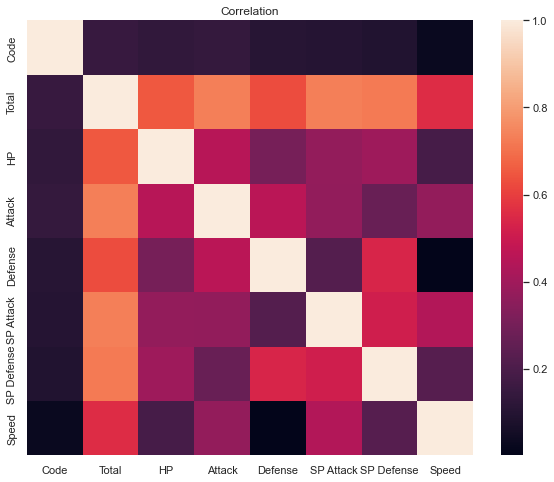

In [50]:
sns.heatmap(df.corr())
plt.title('Correlation')
plt.show()

Sự phân bố của dữ liệu

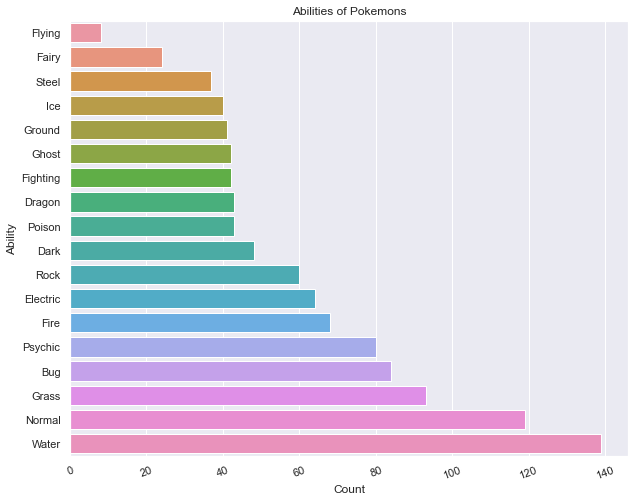

In [49]:
# Phân bố theo hệ của pokemon
count_ability = df.groupby('Type 1').count().reset_index().sort_values(by='Total', ascending=True)
sns.barplot(x='Total',y='Type 1',data=count_ability)
plt.xticks(rotation=20)
plt.title("Abilities of Pokemons")
plt.xlabel("Count")
plt.ylabel("Ability")
plt.show()

Sự tương quan của các chỉ số thông qua hệ chính của pokemon(Type 1)

Pairplot segregated on generation


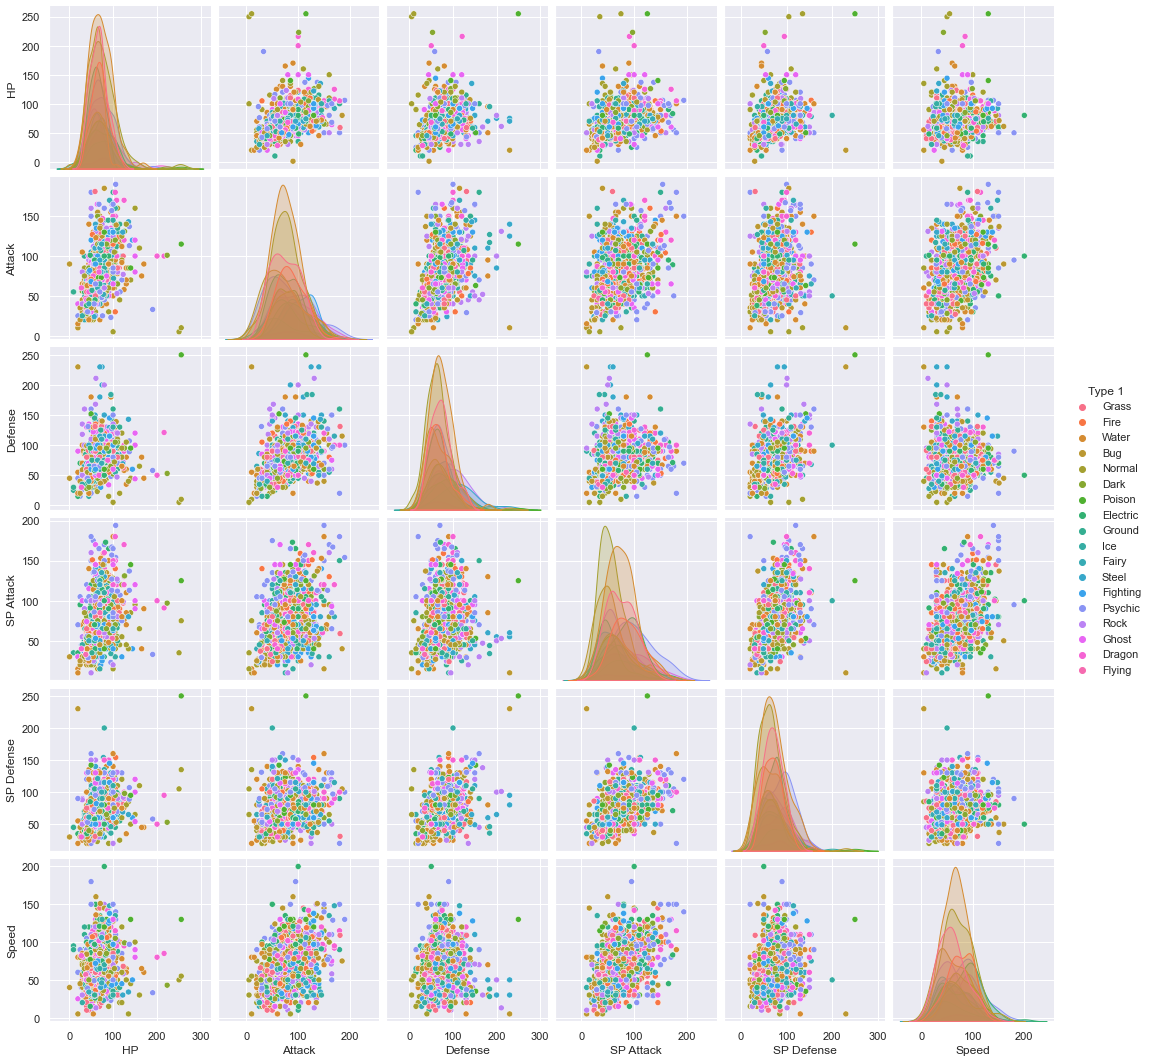

In [52]:
sns.pairplot(data=df[['HP','Attack','Defense','SP Attack','SP Defense','Speed','Type 1']], hue='Type 1')
print('Pairplot segregated on type')
plt.show()

Xem sự tương quan giữa hệ chính và hệ phụ của một pokemon

Text(0.5, 1.0, 'Co-occurence of various pokemon types')

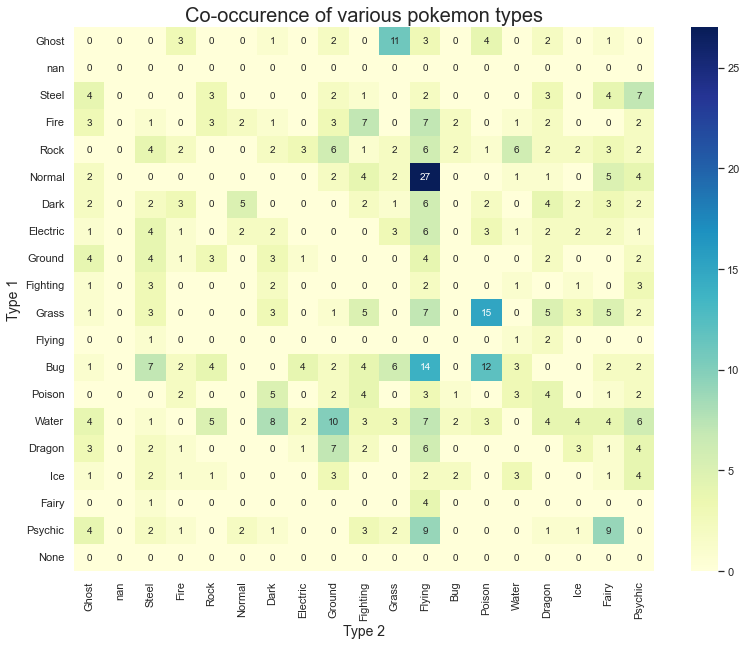

In [54]:
pokemon_types=list(set(df["Type 1"]).union(set(df["Type 2"]))-{"None"})+["None"]

dummy_type_1=pd.get_dummies(df["Type 1"])
dummy_type_2=pd.get_dummies(df["Type 2"])
for poke_type in pokemon_types:
    if poke_type not in dummy_type_1.columns:
        dummy_type_1[poke_type]=0
    if poke_type not in dummy_type_2.columns:
        dummy_type_2[poke_type]=0
heat_df=np.matmul(dummy_type_1[pokemon_types].T,dummy_type_2[pokemon_types])
heat_df.columns=pokemon_types
# I only consider cooccurences...
heat_df.drop(columns=["None"],inplace=True)

plt.figure(figsize=(13,10))
ax = sns.heatmap(heat_df,cmap="YlGnBu",annot=True)
plt.xlabel("Type 2", fontsize=14)
plt.ylabel("Type 1", fontsize=14)
plt.title("Co-occurence of various pokemon types", fontsize=20)

#### 4. Xử lý dữ liệu

3.1 Xử lý dữ liệu trống
- Dữ liệu trống chỉ có ở trường 'Type 2' không ảnh hưởng tới bài toán nên không cần phải xử lý

In [46]:
df.isnull().sum()

Code            0
Name            0
Type 1          0
Type 2        495
Total           0
HP              0
Attack          0
Defense         0
SP Attack       0
SP Defense      0
Speed           0
dtype: int64

3.2 Xử lý ngoại lệ

Text(0.5, 0, 'Attributes')

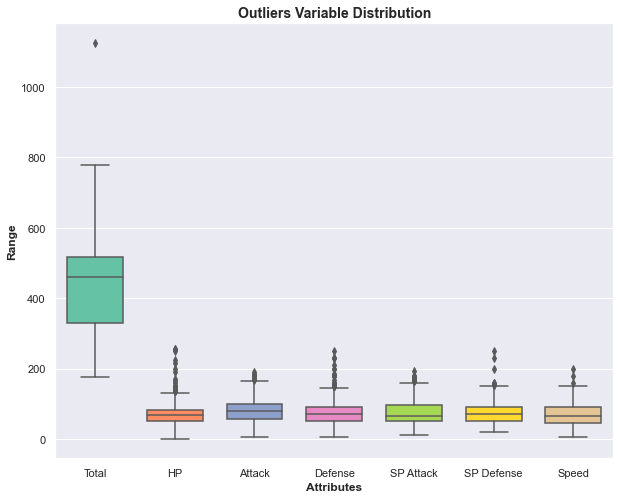

In [47]:
attributes = ['Total', 'HP', 'Attack', 'Defense', 'SP Attack', 'SP Defense', 'Speed']
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = df[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

3.3 Chuẩn hoá dữ liệu để giảm bớt sự ảnh hưởng của dữ liệu lớn

In [48]:
min_max = MinMaxScaler()
df_converted = df[['Total', 'HP', 'Attack', 'Defense', 'SP Attack', 'SP Defense', 'Speed']]
df_minmax = pd.DataFrame(min_max.fit_transform(df_converted), columns=df_converted.columns)

df_minmax.head()


,Total,HP,Attack,Defense,SP Attack,SP Defense,Speed
0,0.150526,0.173228,0.237838,0.179592,0.298913,0.195652,0.205128
1,0.242105,0.232283,0.308108,0.236735,0.380435,0.260870,0.282051
2,0.368421,0.311024,0.416216,0.318367,0.489130,0.347826,0.384615
3,0.473684,0.311024,0.513514,0.481633,0.608696,0.434783,0.384615
4,0.141053,0.149606,0.254054,0.155102,0.271739,0.130435,0.307692
